In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import imdb
import seaborn as sns
import matplotlib.pyplot as plt

### Movies dataset

In [61]:
df_movies = pd.read_csv('data/movies.csv')
df_links = pd.read_csv('data/links.csv')
df_movies = pd.merge(df_movies, df_links, how='left', on='movieId')
df_movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


#### Get years

In [90]:
years = []
titles = []
for i in tqdm(range(len(df_movies))):
    year = df_movies['title'][i].replace(' ','')[-5:].replace(')','')
    if str(year).isnumeric() and len(str(year))==4:
        years.append(year)
    else:
        years.append(np.nan)
df_movies['year'] = years

100%|██████████| 58098/58098 [00:00<00:00, 309489.62it/s]


In [97]:
non_year_df = df_movies[df_movies['year'].isna()][['movieId', 'imdbId', 'title', 'year']].reset_index(drop=True)
non_year_df

,movieId,imdbId,title,year
0,32930,428144,Category 6: Day of Destruction,NaN
1,40697,105946,Babylon 5,NaN
2,79607,66079,"Millions Game, The (Das Millionenspiel)",NaN
3,87442,1710542,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",NaN
4,98063,87738,Mona and the Time of Burning Love (Mona ja pal...,NaN
...,...,...,...,...
323,192339,2781042,The Sign of Three,NaN
324,192829,8032912,Parwaaz Hai Junoon,NaN
325,193149,7398584,¿Qué te juegas?,NaN
326,193443,6756498,Wall,NaN


In [ ]:
ia = imdb.IMDb()
for i in tqdm(range(len(non_year_df))):
    try:
        search = ia.get_movie(str(non_year_df['imdbId'][i]))
        non_year_df.at[i, 'year'] = search['year']
    except Exception as e:
        print(e)
        pass

In [115]:
df_movies_merged = pd.merge(df_movies, non_year_df[['movieId', 'year']], how='left', on='movieId')
df_movies_merged['year'] = [x if len(str(x))==4 else y for x,y in zip(df_movies_merged['year_x'], df_movies_merged['year_y'])]
df_movies_merged.drop(columns=['year_x', 'year_y'], inplace=True)
df_movies_merged

,movieId,title,genres,imdbId,tmdbId,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,1995
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,1995
...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),38566,78251.0,1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,1754787,87558.0,2011
58095,193880,Her Name Was Mumu (2016),Drama,5847740,422666.0,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,4453756,454439.0,2017


In [ ]:
df_movies_merged.to_csv('data/movies_processed.csv', index=False)

#### Get genres

In [141]:
len(df_movies_merged[df_movies_merged['genres']=='(no genres listed)'])/len(df_movies_merged)

0.07342765671795931

In [154]:
non_genres_df = df_movies_merged[df_movies_merged['genres']=='(no genres listed)'].reset_index(drop=True)

In [ ]:
import time

ia = imdb.IMDb()
for i in tqdm(range(len(non_genres_df))):
    try:
        search = ia.get_movie(str(non_genres_df['imdbId'][i]))
        non_genres_df.at[i, 'genres'] = "|".join(search['genre'])
    except Exception as e:
        print(e)
        time.sleep(10)
        try:
            search = ia.get_movie(str(non_genres_df['imdbId'][i]))
            non_genres_df.at[i, 'genres'] = "|".join(search['genre'])
        except:
            pass

In [156]:
df_movies_merged = pd.merge(df_movies_merged, non_genres_df[['movieId', 'genres']], how='left', on='movieId')
df_movies_merged['genres'] = [x if x !='(no genres listed)' else y for x,y in zip(df_movies_merged['genres_x'], df_movies_merged['genres_y'])]
df_movies_merged.drop(columns=['genres_x', 'genres_y'], inplace=True)
df_movies_merged

,movieId,title,imdbId,tmdbId,year,Musical,IMAX,Drama,Mystery,Sci-Fi,...,Crime,Adventure,Thriller,Action,Horror,Documentary,Romance,Western,Children,genres
0,1,Toy Story (1995),114709,862.0,1995,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),113497,8844.0,1995,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),113228,15602.0,1995,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Comedy|Romance
3,4,Waiting to Exhale (1995),114885,31357.0,1995,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),113041,11862.0,1995,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),38566,78251.0,1946,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),1754787,87558.0,2011,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Comedy
58095,193880,Her Name Was Mumu (2016),5847740,422666.0,2016,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drama
58096,193882,Flora (2017),4453756,454439.0,2017,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,Adventure|Drama|Horror|Sci-Fi


In [157]:
len(df_movies_merged[df_movies_merged['genres']=='(no genres listed)'])/len(df_movies_merged)

0.06828118007504562

In [159]:
df_movies_merged.columns

Index(['movieId', 'title', 'imdbId', 'tmdbId', 'year', 'Musical', 'IMAX',
       'Drama', 'Mystery', 'Sci-Fi', 'Fantasy', 'War', 'Comedy', 'Film-Noir',
       'Animation', 'Crime', 'Adventure', 'Thriller', 'Action', 'Horror',
       'Documentary', 'Romance', 'Western', 'Children', 'genres'],
      dtype='object')

In [160]:
df_movies_merged[['movieId', 'title', 'imdbId', 'tmdbId', 'year', 'genres']].to_csv('data/movies_processed.csv', index=False)

In [2]:
df_movies = pd.read_csv('data/movies_processed.csv')
df_movies

,movieId,title,imdbId,tmdbId,year,genres
0,1,Toy Story (1995),114709,862.0,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),113497,8844.0,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),113228,15602.0,1995,Comedy|Romance
3,4,Waiting to Exhale (1995),114885,31357.0,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),113041,11862.0,1995,Comedy
...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),38566,78251.0,1946,(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),1754787,87558.0,2011,Comedy
58095,193880,Her Name Was Mumu (2016),5847740,422666.0,2016,Drama
58096,193882,Flora (2017),4453756,454439.0,2017,Adventure|Drama|Horror|Sci-Fi


In [3]:
all_genres = [x.split('|') for x in df_movies['genres']]
all_genres = list(set([item for sublist in all_genres for item in sublist]))

all_genres.remove('(no genres listed)')
for col in all_genres:
    df_movies[col] = df_movies["genres"].apply(lambda x: 1 if col in x else 0)

In [5]:
df_movies

,movieId,title,imdbId,tmdbId,year,genres,Documentary,Western,Mystery,IMAX,...,Adult,Animation,Comedy,History,Adventure,Romance,War,Musical,Sci-Fi,Action
0,1,Toy Story (1995),114709,862.0,1995,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
1,2,Jumanji (1995),113497,8844.0,1995,Adventure|Children|Fantasy,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),113228,15602.0,1995,Comedy|Romance,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),114885,31357.0,1995,Comedy|Drama|Romance,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),113041,11862.0,1995,Comedy,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),38566,78251.0,1946,(no genres listed),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58094,193878,Les tribulations d'une caissière (2011),1754787,87558.0,2011,Comedy,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
58095,193880,Her Name Was Mumu (2016),5847740,422666.0,2016,Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58096,193882,Flora (2017),4453756,454439.0,2017,Adventure|Drama|Horror|Sci-Fi,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


([<matplotlib.axis.XTick at 0x1699a1fd0>,
 [Text(0, 0, '1874'),
  Text(5, 0, '1890'),
  Text(10, 0, '1895'),
  Text(15, 0, '1900'),
  Text(20, 0, '1905'),
  Text(25, 0, '1910'),
  Text(30, 0, '1915'),
  Text(35, 0, '1920'),
  Text(40, 0, '1925'),
  Text(45, 0, '1930'),
  Text(50, 0, '1935'),
  Text(55, 0, '1940'),
  Text(60, 0, '1945'),
  Text(65, 0, '1950'),
  Text(70, 0, '1955'),
  Text(75, 0, '1960'),
  Text(80, 0, '1965'),
  Text(85, 0, '1970'),
  Text(90, 0, '1975'),
  Text(95, 0, '1980'),
  Text(100, 0, '1985'),
  Text(105, 0, '1990'),
  Text(110, 0, '1995'),
  Text(115, 0, '2000'),
  Text(120, 0, '2005'),
  Text(125, 0, '2010'),
  Text(130, 0, '2015'),
  Text(135, 0, '2020')])

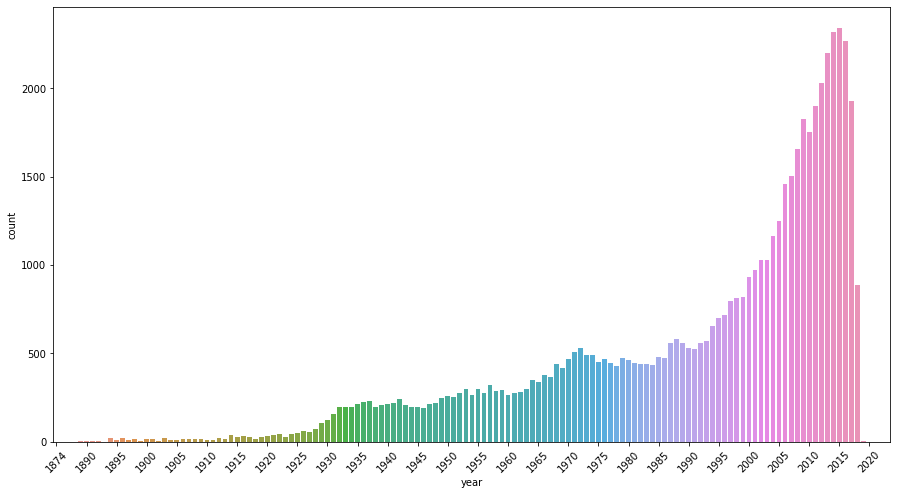

In [18]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(15,8))
np.random.seed(123)
ax = sns.countplot(data=df_movies, x='year')

plt.xticks(rotation=45)
fig.canvas.draw()
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 5), new_ticks[::5])

In [7]:
df_users = pd.read_csv('data/ratings.csv')
df_users.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
df_tags = pd.read_csv('data/tags.csv')
df_tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
